In [26]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, root_mean_squared_error
import lightgbm as lgb
import xgboost as xgb
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt

In [27]:
data = pd.read_csv('combined_exoplanet_data_complete.csv')
data.head()

,orbital_period,planet_radius,transit_duration,transit_depth,equilibrium_temp,insolation_flux,stellar_teff,stellar_radius,stellar_logg,disposition,survey
0,9.488036,2.26,2.95750,615.8,793.0,93.59,5455.0,0.927,4.467,CONFIRMED,Kepler
1,54.418383,2.83,4.50700,874.8,443.0,9.11,5455.0,0.927,4.467,CONFIRMED,Kepler
2,19.899140,14.60,1.78220,10829.0,638.0,39.30,5853.0,0.868,4.544,CANDIDATE,Kepler
3,1.736952,33.46,2.40641,8079.2,1395.0,891.96,5805.0,0.791,4.564,FALSE POSITIVE,Kepler
4,2.525592,2.75,1.65450,603.3,1406.0,926.16,6031.0,1.046,4.438,CONFIRMED,Kepler


In [28]:
train = pd.read_csv("train_labeled_scaled.csv")
test = pd.read_csv("test_labeled_scaled.csv")

In [29]:
feature_cols = [
    'orbital_period', 'planet_radius', 'transit_duration', 
    'transit_depth', 'equilibrium_temp', 'insolation_flux',
    'stellar_teff', 'stellar_radius', 'stellar_logg'
]

In [30]:
feature_cols = [
    'orbital_period', 'planet_radius', 'transit_duration', 
    'transit_depth', 'equilibrium_temp', 'insolation_flux',
    'stellar_teff', 'stellar_radius', 'stellar_logg'
]

X_train = train[feature_cols]
y_train = train['label']
X_test = test[feature_cols]
y_test = test['label']

In [31]:
lgbm_model = lgb.LGBMClassifier(
    max_depth=4,
    n_estimators=400,
    learning_rate=0.1,
    subsample=0.75,
    colsample_bytree=1,
    class_weight='balanced',
    random_state=67,
    verbose=-1,
    num_threads = 1,
    scale_pos_weight =  np.sum(y_train == 0) / np.sum(y_train == 1)
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=67)

# tuning 
grid = {
    'n_estimators': [375, 400, 425], 
}

grid_search = GridSearchCV(
    estimator=lgbm_model,
    param_grid=grid,
    scoring='roc_auc',   # optimize for AUC
    cv=cv,
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validated AUC: ", grid_search.best_score_)

Best parameters found:  {'n_estimators': 400}
Best cross-validated AUC:  0.9511430820421977


In [32]:
xgb_model = xgb.XGBClassifier(
    n_estimators=175,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.75,
    colsample_bytree=1,
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),  # Handle imbalance
    random_state=67,
    gamma=0,
    reg_lambda = .1,
    eval_metric='logloss'
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=67)

grid = {
    # The four original hyperparams need to be in the grid
    'n_estimators': [175, 200, 225], # This needs to be tuned -- no tricks
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=grid,
    scoring='roc_auc',   # optimize for AUC
    cv=cv,
    verbose=0,
    n_jobs=int(os.getenv("SLURM_NPROCS", 1))
)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validated AUC: ", grid_search.best_score_)

Best parameters found:  {'n_estimators': 175}
Best cross-validated AUC:  0.9521778392454865


In [33]:
print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=67,
)

Training Random Forest...


OOB Score: 0.8725792871175976


/miniconda/envs/ml-data-science-kernel-py311/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


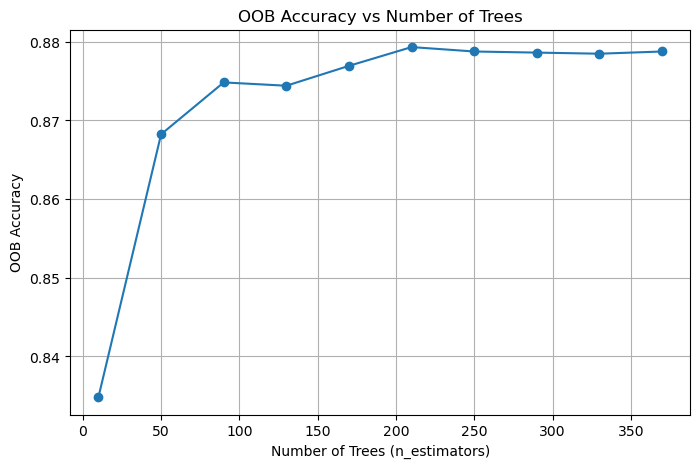

In [34]:
model = RandomForestClassifier(
    n_estimators=250,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=67,
    oob_score = True,
    bootstrap=True
)

model.fit(X_train, y_train)

print("OOB Score:", model.oob_score_)
oob_rmse = []

num_trees = np.arange(10, 400, 40)

oob_scores = []

for n in num_trees:
    model = RandomForestClassifier(
        n_estimators=n,
        random_state=67,
        bootstrap=True,  # Required for OOB
        oob_score=True
    )
    model.fit(X_train, y_train)
    oob_scores.append(model.oob_score_)  # OOB accuracy

# Plot OOB accuracy vs number of trees
plt.figure(figsize=(8,5))
plt.plot(num_trees, oob_scores, marker='o')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("OOB Accuracy")
plt.title("OOB Accuracy vs Number of Trees")
plt.grid(True)
plt.show()

In [35]:
print("Training Extra Trees...")
et_model = ExtraTreesClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=67,
    max_features = None
)

grid = {
    'n_estimators': [250, 300, 350],
}


grid_search = GridSearchCV(
    estimator=et_model,
    param_grid=grid,
    scoring='roc_auc',  # or another metric like 'f1', 'roc_auc'
    cv=5,               # 5-fold cross-validation
    n_jobs=int(os.getenv("SLURM_NPROCS", 1)),          # use all cores
    verbose=0
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Use the best estimator
best_model = grid_search.best_estimator_

Training Extra Trees...
Best parameters found:  {'n_estimators': 300}
Best cross-validation score:  0.9488500276652312


In [36]:
print("Training Logistic Regression...")
lr_model = LogisticRegression(
    C=100,
    class_weight='balanced',
    max_iter=1000,
    random_state=67,
    penalty = 'l2'
)

grid = {
    'C': [0.01, 0.1, 1, 10, 100],      # regularization strength
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
}

# Grid search with 5-fold CV
grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=grid,
    scoring='roc_auc',   # or 'f1', 'roc_auc', etc.
    cv=5,
    n_jobs= int(os.getenv("SLURM_NPROCS", 1)),
    verbose=0
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Use the best model
best_lr = grid_search.best_estimator_

Training Logistic Regression...
Best parameters found:  {'C': 100, 'penalty': 'l2'}
Best cross-validation score:  0.8593413474659222


/miniconda/envs/ml-data-science-kernel-py311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
75 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/miniconda/envs/ml-data-science-kernel-py311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/miniconda/envs/ml-data-science-kernel-py311/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/miniconda/envs/m

In [37]:
base_models = {
    'LightGBM': lgbm_model,
    'XGBoost': xgb_model,
    'RandomForest': rf_model,
    'ExtraTrees': et_model,
    'LogisticRegression': lr_model
}

In [38]:
print("\n=== Generating Out-of-Fold Predictions ===")

# Use 5-fold cross-validation to create meta-features
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=67)

# Store out-of-fold predictions
oof_predictions = np.zeros((len(X_train), len(base_models)))
test_predictions = np.zeros((len(X_test), len(base_models)))

for idx, (name, model) in enumerate(base_models.items()):
    print(f"Processing {name}...")
    
    # Get out-of-fold predictions for training data
    oof_pred = cross_val_predict(
        model, X_train, y_train, 
        cv=skf, method='predict_proba', n_jobs=-1
    )[:, 1]  # Probability of positive class
    
    oof_predictions[:, idx] = oof_pred
    
    # Train on full training data and predict on test
    model.fit(X_train, y_train)
    test_pred = model.predict_proba(X_test)[:, 1]
    test_predictions[:, idx] = test_pred
    
    # Evaluate individual model
    train_auc = roc_auc_score(y_train, oof_pred)
    test_auc = roc_auc_score(y_test, test_pred)
    print(f"  Train AUC: {train_auc:.4f}, Test AUC: {test_auc:.4f}")


=== Generating Out-of-Fold Predictions ===
Processing LightGBM...
  Train AUC: 0.9510, Test AUC: 0.9518
Processing XGBoost...
  Train AUC: 0.9521, Test AUC: 0.9534
Processing RandomForest...
  Train AUC: 0.9430, Test AUC: 0.9482
Processing ExtraTrees...
  Train AUC: 0.9487, Test AUC: 0.9520
Processing LogisticRegression...
  Train AUC: 0.8591, Test AUC: 0.8645


In [39]:
meta_model_lr = LogisticRegression(
    C=1.0,
    class_weight='balanced',
    random_state=67
)
meta_model_lr.fit(oof_predictions, y_train)
stacked_pred_lr = meta_model_lr.predict_proba(test_predictions)[:, 1]
stacked_auc_lr = roc_auc_score(y_test, stacked_pred_lr)

print(f"Meta-Learner (Logistic Regression) AUC: {stacked_auc_lr:.4f}")

Meta-Learner (Logistic Regression) AUC: 0.9555


In [40]:
# Option 2: LightGBM meta-learner (as in the paper)
meta_model_lgbm = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    class_weight='balanced',
    random_state=67,
    verbose=-1
)
meta_model_lgbm.fit(oof_predictions, y_train)
stacked_pred_lgbm = meta_model_lgbm.predict_proba(test_predictions)[:, 1]
stacked_auc_lgbm = roc_auc_score(y_test, stacked_pred_lgbm)
print(f"Meta-Learner (LightGBM) AUC: {stacked_auc_lgbm:.4f}")

Meta-Learner (LightGBM) AUC: 0.9556


In [41]:
avg_pred = test_predictions.mean(axis=1)
avg_auc = roc_auc_score(y_test, avg_pred)
print(f"Simple Average AUC: {avg_auc:.4f}")

Simple Average AUC: 0.9530


In [42]:
print("\n=== Final Model Evaluation ===")

# Choose best meta-learner
if stacked_auc_lgbm > stacked_auc_lr:
    best_meta = meta_model_lgbm
    best_pred = stacked_pred_lgbm
    best_name = "LightGBM"
else:
    best_meta = meta_model_lr
    best_pred = stacked_pred_lr
    best_name = "Logistic Regression"

print(f"Best Meta-Learner: {best_name}")
print(f"Best Stacked Model AUC: {max(stacked_auc_lr, stacked_auc_lgbm):.4f}")

# Convert probabilities to binary predictions (threshold = 0.5)
best_pred_binary = (best_pred >= 0.5).astype(int)


print("\nClassification Report:")
print(classification_report(y_test, best_pred_binary, 
                          target_names=['FALSE POSITIVE', 'CONFIRMED']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, best_pred_binary)
print(f"TN: {cm[0,0]}, FP: {cm[0,1]}")
print(f"FN: {cm[1,0]}, TP: {cm[1,1]}")

# Feature importance from meta-learner
if best_name == "Logistic Regression":
    print("\nMeta-Model Weights (contribution of each base model):")
    for i, name in enumerate(base_models.keys()):
        weight = meta_model_lr.coef_[0][i]
        print(f"  {name}: {weight:.4f}")


if best_name == "LightGBM":
    print("\nMeta-Model Feature Importances (contribution of each base model):")
    importances = best_meta.feature_importances_
    
    for name, importance in zip(base_models.keys(), importances):
        print(f"  {name}: {importance:.4f}")
        
        
print("\n=== Base Model Feature Importances ===")

for name, model in base_models.items():
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        sorted_idx = np.argsort(importances)[::-1]
        print(f"\n{name} Top Feature Importances:")
        for i in sorted_idx[:10]:  # top 10 features
            print(f"  {X_train.columns[i]}: {importances[i]:.4f}")
    else:
        print(f"\n{name} does not provide feature importances.")



=== Final Model Evaluation ===
Best Meta-Learner: LightGBM
Best Stacked Model AUC: 0.9556

Classification Report:
                precision    recall  f1-score   support

FALSE POSITIVE       0.94      0.86      0.90      1383
     CONFIRMED       0.82      0.92      0.87       993

      accuracy                           0.88      2376
     macro avg       0.88      0.89      0.88      2376
  weighted avg       0.89      0.88      0.88      2376


Confusion Matrix:
TN: 1184, FP: 199
FN: 76, TP: 917

Meta-Model Feature Importances (contribution of each base model):
  LightGBM: 161.0000
  XGBoost: 211.0000
  RandomForest: 47.0000
  ExtraTrees: 212.0000
  LogisticRegression: 62.0000

=== Base Model Feature Importances ===

LightGBM Top Feature Importances:
  transit_duration: 861.0000
  orbital_period: 672.0000
  planet_radius: 647.0000
  transit_depth: 631.0000
  stellar_teff: 598.0000
  stellar_radius: 529.0000
  stellar_logg: 470.0000
  equilibrium_temp: 428.0000
  insolation_flux: 

In [43]:
candidates = pd.read_csv('candidates_unlabeled_scaled.csv')
candidates

,orbital_period,planet_radius,transit_duration,transit_depth,equilibrium_temp,insolation_flux,stellar_teff,stellar_radius,stellar_logg,survey,original_index
0,-0.205305,-0.024155,-0.547287,-0.162470,-0.645087,-0.062698,0.122805,-0.141480,0.554012,Kepler,2
1,-0.008698,-0.026392,-0.286114,-0.221179,-0.838709,-0.062964,-0.267757,-0.157420,0.465187,Kepler,58
2,-0.326587,-0.022625,-0.749673,-0.294350,-0.536388,-0.062419,-0.690947,-0.160352,0.676446,Kepler,62
3,-0.363040,-0.028588,-0.323972,-0.301196,0.072784,-0.057204,0.051794,-0.101355,0.061873,Kepler,63
4,-0.298409,-0.026323,-0.261828,-0.227789,-0.448069,-0.062094,0.252353,-0.147343,0.546810,Kepler,84
...,...,...,...,...,...,...,...,...,...,...,...
5893,-0.348191,-0.027881,-0.234990,-0.292631,-0.224015,-0.060736,-0.514378,-0.105327,0.040266,TESS,15809
5894,-0.269815,-0.025168,-0.070205,-0.228355,-0.292945,-0.061790,0.617006,-0.022020,-0.319835,TESS,15812
5895,-0.352008,-0.025407,-0.121124,-0.258858,1.198280,-0.021422,2.555424,0.040275,-0.223808,TESS,15822
5896,-0.372157,-0.024686,-0.511446,-0.282545,2.881995,0.250035,3.963177,0.089745,-0.319835,TESS,15823


In [44]:
print("\n=== Predicting on Unlabeled Candidates ===")
# Load the unlabeled candidates
candidates = pd.read_csv('candidates_unlabeled_scaled.csv')
print(f"Loaded {len(candidates)} unlabeled candidates")

# ===== FIX: Handle non-numeric columns =====
# Check for non-numeric columns
non_numeric_cols = candidates.select_dtypes(include=['object']).columns.tolist()
if non_numeric_cols:
    print(f"\nWarning: Found non-numeric columns: {non_numeric_cols}")
    print("Dropping these columns for prediction...")
    candidates = candidates.drop(columns=non_numeric_cols)

# Also ensure we're only using the same features that were used in training
# Get feature names from one of the base models
feature_names = base_models['LightGBM'].feature_name_
print(f"\nUsing {len(feature_names)} features from training")

# Ensure candidates has exactly these features in the same order
missing_features = set(feature_names) - set(candidates.columns)
extra_features = set(candidates.columns) - set(feature_names)

if missing_features:
    print(f"Warning: Missing features in candidates: {missing_features}")
if extra_features:
    print(f"Note: Extra columns in candidates (will be dropped): {extra_features}")

# Select only the features used in training, in the correct order
candidates_features = candidates[feature_names]

# Generate predictions from all base models
print("\nGenerating base model predictions...")
candidate_predictions = np.zeros((len(candidates_features), len(base_models)))
for idx, (name, model) in enumerate(base_models.items()):
    print(f"  Predicting with {name}...")
    # Each base model should already be trained on full X_train
    pred = model.predict_proba(candidates_features)[:, 1]
    candidate_predictions[:, idx] = pred

# Use the tuned meta-learner (or original if tuning didn't help)
print("\nApplying meta-learner...")
# Use best_meta_model from tuning, or retrain on full data:
final_meta_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    class_weight='balanced',
    random_state=67,
    verbose=-1
)
final_meta_model.fit(oof_predictions, y_train)

# Get final stacked predictions
final_predictions = final_meta_model.predict_proba(candidate_predictions)[:, 1]

# Add predictions to the ORIGINAL dataframe (so we keep all columns including 'survey')
candidates['exoplanet_probability'] = final_predictions

# Sort by probability and get top 10
top_10_candidates = candidates.nlargest(10, 'exoplanet_probability')

# Get feature importances from the best base model and select top 3
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': base_models['LightGBM'].feature_importances_
}).sort_values('importance', ascending=False)

top_3_features = feature_importance.head(3)['feature'].tolist()

print("\n" + "="*80)
print("TOP 10 MOST LIKELY EXOPLANET CANDIDATES")
print("="*80)

# Display with index and top 3 features only
for i, (idx, row) in enumerate(top_10_candidates.iterrows(), 1):
    print(f"\nRank {i}: Candidate {idx}")
    
    # Show top 3 feature values
    print(f"  Top 3 Features:")
    for feat in top_3_features:
        print(f"    {feat}: {row[feat]:.4f}")

print("\n" + "="*80)

# Summary statistics
print(f"\nPrediction Statistics:")
print(f"  Mean probability: {final_predictions.mean():.4f}")
print(f"  Median probability: {np.median(final_predictions):.4f}")
print(f"  Std deviation: {final_predictions.std():.4f}")
print(f"  Min probability: {final_predictions.min():.4f}")
print(f"  Max probability: {final_predictions.max():.4f}")

# Distribution of predictions
print(f"\nPrediction Distribution:")
bins = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
for i in range(len(bins)-1):
    count = np.sum((final_predictions >= bins[i]) & (final_predictions < bins[i+1]))
    pct = count / len(final_predictions) * 100
    print(f"  {bins[i]:.1f} - {bins[i+1]:.1f}: {count:5d} candidates ({pct:5.2f}%)")

# Save results
output_file = 'candidate_predictions.csv'
candidates.to_csv(output_file, index=False)
print(f"\nFull predictions saved to: {output_file}")

# Create a summary file with just top candidates
top_100 = candidates.nlargest(100, 'exoplanet_probability')
top_100.to_csv('top_100_candidates.csv', index=False)
print(f"Top 100 candidates saved to: top_100_candidates.csv")


=== Predicting on Unlabeled Candidates ===
Loaded 5898 unlabeled candidates

Dropping these columns for prediction...

Using 9 features from training
Note: Extra columns in candidates (will be dropped): {'original_index'}

Generating base model predictions...
  Predicting with LightGBM...
  Predicting with XGBoost...
  Predicting with RandomForest...
  Predicting with ExtraTrees...
  Predicting with LogisticRegression...

Applying meta-learner...

TOP 10 MOST LIKELY EXOPLANET CANDIDATES

Rank 1: Candidate 515
  Top 3 Features:
    transit_duration: -0.1967
    orbital_period: -0.2973
    planet_radius: -0.0283

Rank 2: Candidate 689
  Top 3 Features:
    transit_duration: -0.3875
    orbital_period: -0.2868
    planet_radius: -0.0282

Rank 3: Candidate 826
  Top 3 Features:
    transit_duration: 0.5904
    orbital_period: 0.3929
    planet_radius: -0.0281

Rank 4: Candidate 905
  Top 3 Features:
    transit_duration: 0.4286
    orbital_period: 0.9608
    planet_radius: -0.0278

Rank 5

,orbital_period,planet_radius,transit_duration,transit_depth,equilibrium_temp,insolation_flux,stellar_teff,stellar_radius,stellar_logg,disposition,survey
0,9.488036,2.26,2.95750,615.8,793.0,93.59,5455.0,0.927,4.467,CONFIRMED,Kepler
1,54.418383,2.83,4.50700,874.8,443.0,9.11,5455.0,0.927,4.467,CONFIRMED,Kepler
2,19.899140,14.60,1.78220,10829.0,638.0,39.30,5853.0,0.868,4.544,CANDIDATE,Kepler
3,1.736952,33.46,2.40641,8079.2,1395.0,891.96,5805.0,0.791,4.564,FALSE POSITIVE,Kepler
4,2.525592,2.75,1.65450,603.3,1406.0,926.16,6031.0,1.046,4.438,CONFIRMED,Kepler
